# Tuned Mass Damper Analytic

# Packages

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

# Package for SpringPatch and DampingPatch
from matplotlib import patches, path

# Packages for Animation
from matplotlib import animation
from matplotlib import rc

# Differential Equation Solver
from scipy.integrate import odeint

# Install the 'ipympl' package silently
!pip install ipympl > /dev/null

## Mouse Interactive Notebook

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import solve_ivp
from matplotlib.patches import Arc
import time

# ipympl enables the use of interactive features of Matplotlib within Jupyter Notebooks
%matplotlib ipympl

# Import the necessary module from Google Colab to enable the custom widget manager
from google.colab import output
output.enable_custom_widget_manager()

# Physical Problem Drawing Code

## Spring Patch (Adapted from "github.com/nrsyed/utilities/tree/master/spring")

In [ ]:
class SpringPatch(patches.PathPatch):

    def __init__(self, start_point, end_point, num_nodes, spring_width, **kwargs):
        self.start_point = np.array(start_point)
        self.end_point = np.array(end_point)
        self.num_nodes = num_nodes
        self.spring_width = spring_width

        # Ensure 'facecolor' is set to 'none' unless specified otherwise in kwargs
        if 'facecolor' not in kwargs:
            kwargs['facecolor'] = 'none'
        self.kwargs = kwargs

        # Generate the path for the spring and initialize the PathPatch
        spring_path = self._generate_spring_path()
        super().__init__(spring_path, **kwargs)

    def _generate_spring_path(self):
        """
        Generates the path representing the spring between start_point and end_point.
        """
        # Generate the spring coordinates
        x_coords, y_coords = self._calculate_spring_coords(self.start_point, self.end_point, self.num_nodes, self.spring_width)

        # Create vertices for the path
        vertices = np.array([x_coords, y_coords]).T

        # Define the path codes: move to the first point, then draw lines to each subsequent point
        path_codes = [path.Path.MOVETO] + [path.Path.LINETO] * (len(vertices) - 1)

        return path.Path(vertices, path_codes)

    def _calculate_spring_coords(self, start, end, nodes, width):
        """
        Calculate the coordinates for the spring shape.

        Parameters:
        start (np.array): Starting point of the spring.
        end (np.array): Ending point of the spring.
        nodes (int): Number of nodes in the spring.
        width (float): Width of the spring.

        Returns:
        tuple: Arrays of x and y coordinates of the spring.
        """
        nodes = max(int(nodes), 1)
        start, end = np.array(start).reshape((2,)), np.array(end).reshape((2,))

        # Handle the special case where start and end points are identical
        if np.array_equal(start, end):
            return [start[0]], [start[1]]

        # Calculate the unit direction vector from start to end
        length = np.linalg.norm(end - start)
        unit_tangent = (end - start) / length
        unit_normal = np.array([[0, -1], [1, 0]]).dot(unit_tangent)

        # Initialize the spring coordinates
        spring_coords = np.zeros((2, nodes + 2))
        spring_coords[:, 0], spring_coords[:, -1] = start, end

        # Calculate the normal distance for the nodes
        normal_distance = np.sqrt(max(0, width**2 - (length**2 / nodes**2))) / 2

        # Calculate the position of each node
        for i in range(1, nodes + 1):
            spring_coords[:, i] = (
                start
                + ((length * (2 * i - 1) * unit_tangent) / (2 * nodes))
                + (normal_distance * (-1)**i * unit_normal))

        return spring_coords[0, :], spring_coords[1, :]

    def update_spring(self, new_start, new_end):
        """
        Update the spring with new start and end points.

        Parameters:
        new_start (np.array): New starting point of the spring.
        new_end (np.array): New ending point of the spring.
        """
        self.start_point = np.array(new_start)
        self.end_point = np.array(new_end)
        spring_path = self._generate_spring_path()
        self.set_path(spring_path)

## Damping Patch

In [ ]:
class DampingPatch(patches.PathPatch):
    def __init__(self, start, end, lengthBase, lengthTop, lengthBox, width, edgecolor='black', **kwargs):
        """
        Initialize a DampingPatch object.

        Parameters:
            start (tuple): Coordinates (x, y) of the start point.
            end (tuple): Coordinates (x, y) of the end point.
            length (float): Length of the patch.
            width (float): Width of the patch.
            edgecolor (str): Edge color of the patch.
            kwargs: Additional keyword arguments for PathPatch.
        """
        # Initialize start and end points
        self.x_start, self.y_start = start
        self.x_end, self.y_end = end

        # Initialize patch dimensions and edge color
        self.lengthBase = lengthBase
        self.lengthTop = lengthTop
        self.lengthBox = lengthBox
        self.width = width
        self.edgecolor = edgecolor

        # Ensure 'facecolor' is set to 'none' unless specified otherwise in kwargs
        if 'facecolor' not in kwargs:
            kwargs['facecolor'] = 'none'

        # Create the patch path
        path = self.create_path()

        # Initialize the PathPatch with the created path and specified attributes
        super().__init__(path, edgecolor=edgecolor, **kwargs)

    def create_path(self):
        """
        Create the path for the DampingPatch.

        Returns:
            patches.Path: The path object for the patch.
        """
        # Calculate the differences in x and y coordinates
        dx = self.x_end - self.x_start
        dy = self.y_end - self.y_start

        # Define dimensions for various parts of the patch
        lower_line_length = self.lengthBase
        upper_line_length = self.lengthTop
        box_height = self.lengthBox

        # Calculate the angle of the patch
        theta = np.arctan2(dy, dx)

        # Calculate coordinates for the lower line
        self.x_lower_start = self.x_start + lower_line_length * np.cos(theta)
        self.y_lower_start = self.y_start + lower_line_length * np.sin(theta)
        self.x_upper_end = self.x_end - upper_line_length * np.cos(theta)
        self.y_upper_end = self.y_end - upper_line_length * np.sin(theta)

        # Calculate box corner coordinates
        self.x_upper_left = self.x_upper_end + 0.5 * self.width * np.cos(np.pi/2 + theta)
        self.y_upper_left = self.y_upper_end + 0.5 * self.width * np.sin(np.pi/2 + theta)
        self.x_upper_right = self.x_upper_end - 0.5 * self.width * np.cos(np.pi/2 + theta)
        self.y_upper_right = self.y_upper_end - 0.5 * self.width * np.sin(np.pi/2 + theta)

        self.x_lower_left = self.x_lower_start + 0.5 * self.width * np.cos(np.pi/2 + theta)
        self.y_lower_left = self.y_lower_start + 0.5 * self.width * np.sin(np.pi/2 + theta)
        self.x_lower_right = self.x_lower_start - 0.5 * self.width * np.cos(np.pi/2 + theta)
        self.y_lower_right = self.y_lower_start - 0.5 * self.width * np.sin(np.pi/2 + theta)

        self.x_box_upper_left = self.x_lower_left + box_height * np.cos(theta)
        self.y_box_upper_left = self.y_lower_left + box_height * np.sin(theta)
        self.x_box_upper_right = self.x_lower_right + box_height * np.cos(theta)
        self.y_box_upper_right = self.y_lower_right + box_height * np.sin(theta)

        # Define the vertices and codes for the patch path
        vertices = [
            (self.x_start, self.y_start), (self.x_lower_start, self.y_lower_start),
            (self.x_lower_left, self.y_lower_left), (self.x_box_upper_left, self.y_box_upper_left),
            (self.x_lower_start, self.y_lower_start), (self.x_lower_right, self.y_lower_right),
            (self.x_box_upper_right, self.y_box_upper_right), (self.x_upper_left, self.y_upper_left),
            (self.x_upper_right, self.y_upper_right), (self.x_upper_end, self.y_upper_end),
            (self.x_end, self.y_end)
        ]
        codes = [
            patches.Path.MOVETO, patches.Path.LINETO, patches.Path.LINETO,
            patches.Path.LINETO, patches.Path.MOVETO, patches.Path.LINETO,
            patches.Path.LINETO, patches.Path.MOVETO, patches.Path.LINETO,
            patches.Path.LINETO, patches.Path.LINETO
        ]

        # Create and return the path
        path = patches.Path(vertices, codes)
        return path

    def update_endpoints(self, start, end):
        """
        Update the endpoints of the DampingPatch and recreate the path.

        Parameters:
            start (tuple): New start coordinates (x, y).
            end (tuple): New end coordinates (x, y).
        """
        # Update start and end coordinates
        self.x_start, self.y_start = start
        self.x_end, self.y_end = end

        # Create a new path with the updated coordinates
        new_path = self.create_path()

        # Update the PathPatch path
        self.set_path(new_path)


## Diagram

In [ ]:
mass_1_Size = 2
mass_2_Size = 1

mass_1_Equilibrium_Position = 10
mass_2_Equilibrium_Position = 20

wall_Width = 1/2

x_Min = -wall_Width
x_Max = 25

y_Min = 0
y_Max = 5

spring_Heigth = y_Max/2 + 3/10 * mass_2_Size
spring_Nodes = 15
spring_Width = 7/10

damper_Heigth = y_Max/2 - 3/10 * mass_2_Size
damper_Width = 1/2
damper_lengthBase = 1
damper_lengthTop = 5
damper_lengthBox = 6

Text(20.25, 3.5, '$x_2$')

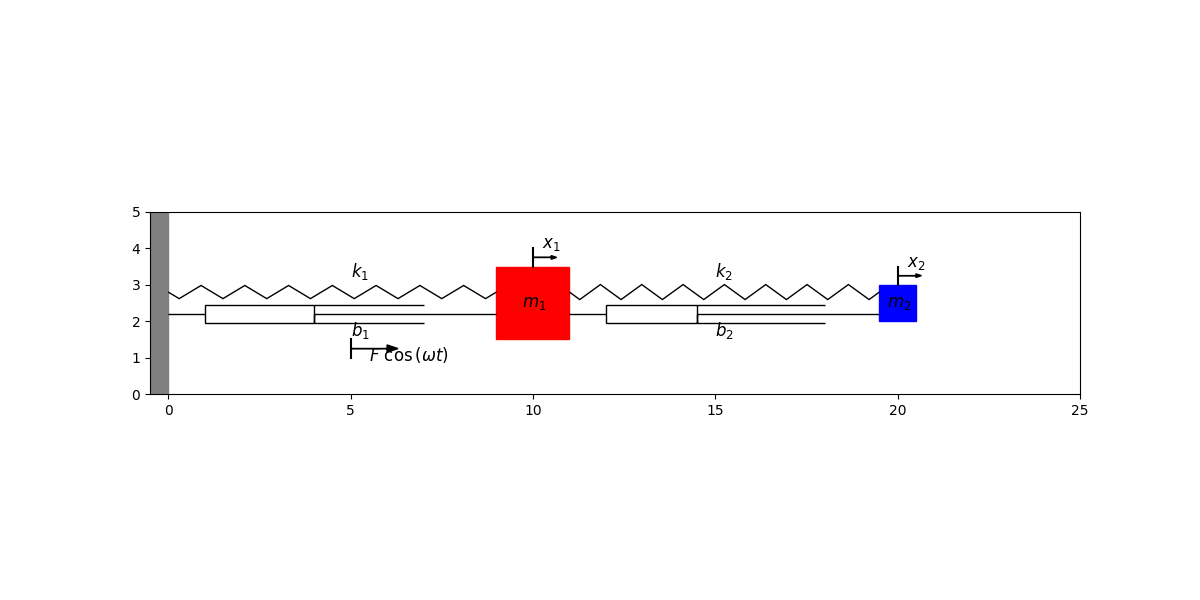

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set axis limits and labels

ax.set_xlim(x_Min, x_Max)
ax.set_ylim(y_Min, y_Max)

# Set aspect ratio to equal, i.e. circles are shown as circles

ax.set_aspect('equal')

# Draw Wall

wall_Left = plt.Rectangle((-wall_Width, 0.), wall_Width, y_Max, color='grey')

ax.add_patch(wall_Left)

# Draw Masses

mass_1 = plt.Rectangle((- 1/2 * mass_1_Size + mass_1_Equilibrium_Position, y_Max/2 - mass_1_Size/2), mass_1_Size, mass_1_Size, color='red')
mass_2 = plt.Rectangle((- 1/2 * mass_2_Size + mass_2_Equilibrium_Position, y_Max/2 - mass_2_Size/2), mass_2_Size, mass_2_Size, color='blue')

ax.add_patch(mass_1)
ax.add_patch(mass_2)

# Draw Springs

spring_1 = SpringPatch((0, spring_Heigth), (mass_1_Equilibrium_Position - mass_1_Size/2, spring_Heigth), spring_Nodes, spring_Width, edgecolor='black')
spring_2 = SpringPatch((mass_1_Equilibrium_Position + mass_1_Size/2, spring_Heigth), (mass_2_Equilibrium_Position - mass_2_Size/2, spring_Heigth), spring_Nodes, spring_Width, edgecolor='black')

ax.add_patch(spring_1)
ax.add_patch(spring_2)

# Draw Damping Element

damper_1 = DampingPatch((0, damper_Heigth), (mass_1_Equilibrium_Position - mass_1_Size/2, damper_Heigth), damper_lengthBase, damper_lengthTop, damper_lengthBox, damper_Width, edgecolor='black')
damper_2 = DampingPatch((mass_1_Equilibrium_Position + mass_1_Size/2, damper_Heigth), (mass_2_Equilibrium_Position - mass_2_Size/2, damper_Heigth), damper_lengthBase, damper_lengthTop, damper_lengthBox, damper_Width, edgecolor='black')

ax.add_patch(damper_1)
ax.add_patch(damper_2)

# Label physical parameters

plt.text(5, 3.2, r'$k_1$', fontsize=12)
plt.text(15, 3.2, r'$k_2$', fontsize=12)

plt.text(5, 1.6, r'$b_1$', fontsize=12)
plt.text(15, 1.6, r'$b_2$', fontsize=12)

plt.text(9.7, 2.4, r'$m_1$', fontsize=12)
plt.text(19.7, 2.4, r'$m_2$', fontsize=12)

plt.plot([5, 5], [1, 1.5], 'black')
plt.arrow(5, 1.25, 1, 0, head_width=0.2, fc='k', ec='k')
plt.text(5.5, 0.9, r'$F\ \cos{(\omega t)}$', fontsize=12)

plt.plot([10, 10], [3.5, 4], 'black')
plt.arrow(10, 3.75, 0.5, 0, head_width=0.1, fc='k', ec='k')
plt.text(10.25, 4, r'$x_1$', fontsize=12)

plt.plot([20, 20], [3, 3.5], 'black')
plt.arrow(20, 3.25, 0.5, 0, head_width=0.1, fc='k', ec='k')
plt.text(20.25, 3.5, r'$x_2$', fontsize=12)

## Physical Problem

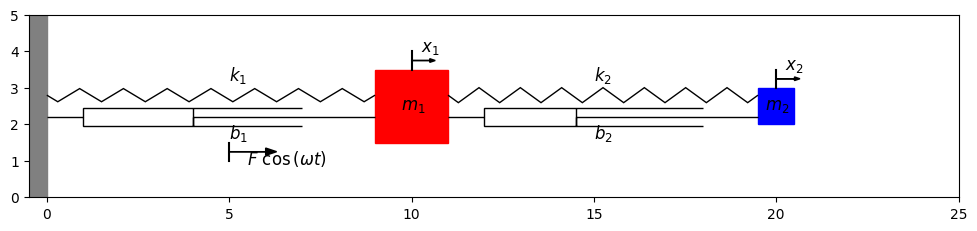

In [ ]:
fig

Set Physical Parameters

In [ ]:
k1 = 1
b1 = 0.1
m1 = 1

## Tuning Parameters with Bode Plot

### Dynamic Plot

In [ ]:
omega_Min = 0.1
omega_Max = 10
omega_Number_of_Dots = 1000

In [ ]:
omega_Array = np.linspace(omega_Min, omega_Max, omega_Number_of_Dots)

In [ ]:
def re_Fourier_Transform_of_x (omega, k1, b1, m1, k2, b2, m2):
  numerator = (k2**2 * (m1 + m2) * omega**2 +
             (b2**2 * (m1 + m2) - k2 * m2 * (2 * m1 + m2)) * omega**4 +
             m1 * m2**2 * omega**6 -
             k1 * (b2**2 * omega**2 + (k2 - m2 * omega**2)**2))
  denominator = (k1**2 * k2**2 +
               (b2**2 * k1**2 + k2 * (b1**2 * k2 - 2 * k1 * (k2 * m1 + (k1 + k2) * m2))) * omega**2 +
               (k2**2 * m1**2 + 2 * k2 * (2 * k1 + k2) * m1 * m2 + (k1 + k2)**2 * m2**2 -
                2 * b2**2 * k1 * (m1 + m2) + b1**2 * (b2**2 - 2 * k2 * m2)) * omega**4 +
               (2 * b1 * b2 * m2**2 + b2**2 * (m1 + m2)**2 +
                m2 * (b1**2 * m2 - 2 * m1 * (k1 * m2 + k2 * (m1 + m2)))) * omega**6 +
               m1**2 * m2**2 * omega**8)
  return numerator/denominator

def im_Fourier_Transform_of_x (omega, k1, b1, m1, k2, b2, m2):
  numerator = b2 * m2**2 * omega**5 + b1 * omega * (b2**2 * omega**2 + (k2 - m2 * omega**2)**2)
  denominator = (k1**2 * k2**2 +
               (b2**2 * k1**2 + k2 * (b1**2 * k2 - 2 * k1 * (k2 * m1 + (k1 + k2) * m2))) * omega**2 +
               (k2**2 * m1**2 + 2 * k2 * (2 * k1 + k2) * m1 * m2 + (k1 + k2)**2 * m2**2 -
                2 * b2**2 * k1 * (m1 + m2) + b1**2 * (b2**2 - 2 * k2 * m2)) * omega**4 +
               (2 * b1 * b2 * m2**2 + b2**2 * (m1 + m2)**2 +
                m2 * (b1**2 * m2 - 2 * m1 * (k1 * m2 + k2 * (m1 + m2)))) * omega**6 +
               m1**2 * m2**2 * omega**8)
  return numerator/denominator

def norm_Fourier_Transform_of_x (omega, k1, b1, m1, k2, b2, m2):
  return np.sqrt( re_Fourier_Transform_of_x(omega, k1, b1, m1, k2, b2, m2)**2 + im_Fourier_Transform_of_x(omega, k1, b1, m1, k2, b2, m2)**2 )

norm_Fourier_Transform_of_x_Vectorized = np.vectorize(norm_Fourier_Transform_of_x, excluded=['k1', 'b1', 'm1', 'k2', 'b2', 'm2'])

In [ ]:
def Bode_Plot(omega_Array, k2_Value=0.08, b2_Value=0.03, m2_Value=0.1):

    x1_Array = 10 * np.log10(norm_Fourier_Transform_of_x_Vectorized(omega_Array, k1, b1, m1, k2_Value, b2_Value, m2_Value))
    x1_Untuned_Array = 10 * np.log10(norm_Fourier_Transform_of_x_Vectorized(omega_Array, k1, b1, m1, k2_Value, b2_Value, 0))

    plt.figure(figsize=(5, 3))

    plt.semilogx(omega_Array, x1_Array, label='x1_Tuned')
    plt.semilogx(omega_Array, x1_Untuned_Array, label='x1_Untuned')

    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Magnitude (dB)')

    # Set the range for the x-axis
    plt.xlim(omega_Min, omega_Max)
    plt.ylim(-20, 20)

    plt.legend()
    plt.show()

### Bode Plot

In [ ]:
# Create an interactive widget for omega
widget = ipywidgets.interactive(Bode_Plot, omega_Array=ipywidgets.fixed(omega_Array), k2_Value=(0., 0.5, 0.1), b2_Value=(0.01, 0.1, 0.01), m2_Value=(0, 0.5, 0.1))

display(widget)

interactive(children=(FloatSlider(value=0.08, description='k2_Value', max=0.5), FloatSlider(value=0.03, descri…

In [ ]:
k2 = 0.08
b2 = 0.1
m2 = 0.1

## Motion

### Parameters and Initial Conditions

In [ ]:
F = 1/5
omega = 2

to = 0
tf = 30
dt = 1/10

x10 = 0
x20 = 0
x10_Prime = 0
x20_Prime = 0

## Differential Equation Solver

In [ ]:
t_List = np.linspace(to, tf, 1 + round(tf/dt))

In [ ]:
k_Matrix = np.array([[-k1-k2, k2], [k2, -k2]])
b_Matrix = np.array([[-b1-b2, b2], [b2, -b2]])
m_Matrix = np.array([[m1, 0], [0, m2]])

In [ ]:
# Define the ODE system
def odes(t, y):
    y1 = y[:2]
    y2 = y[2:]

    F_Matrix = np.array([F * np.cos(omega * t), 0])

    dy1dt = y2
    dy2dt = np.dot(np.linalg.inv(m_Matrix), (F_Matrix - np.dot(b_Matrix, y2) - np.dot(k_Matrix, y1)))

    return np.concatenate((dy1dt, dy2dt))

In [ ]:
def coupled_oscillators(y, t):
    x1, v1, x2, v2 = y
    dydt = [
        v1,
        (F * np.cos(omega * t) - b1 * v1 - k1 * x1 - b2 * (v1 - v2) - k2 * (x1 - x2)) / m1,
        v2,
        (b2 * (v1 - v2) + k2 * (x1 - x2)) / m2
    ]
    return dydt

## Phase Portrait Interactive Code

In [ ]:
def on_click(event, ax):

  # Get mouse click coordinates
  x = event.xdata
  y = event.ydata

  if x is None or y is None:
      return

  # Recompute the solution with new initial conditions
  solution = odeint(coupled_oscillators, np.array([x, y, 0, 0]), t_List)

  x1 = solution[:, 0]
  x2 = solution[:, 2]
  x1_prime = solution[:, 1]
  x2_prime = solution[:, 3]

  # Clear the previous plot
  ax.cla()

  # Plot the new phase portraits
  ax.plot(x1, x1_prime, label='Mass 1', color='red')
  ax.plot(x2, x2_prime, label='Mass 2', color='blue')

  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)

  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_title('Phase Portrait')
  ax.grid(True)
  ax.legend()

  # Redraw the canvas
  ax.figure.canvas.draw()

In [ ]:
def phase_Portrait(x10, x10_Prime, x20, x20_Prime):

  solution = odeint(coupled_oscillators, np.array([x10, x10_Prime, x20, x20_Prime]), t_List)

  x1 = solution[:, 0]
  x2 = solution[:, 2]
  x1_prime = solution[:, 1]
  x2_prime = solution[:, 3]

  # Plotting phase portraits on the same plot

  fig, ax = plt.subplots()

  ax.plot(x1, x1_prime, label='Mass 1', color='red')
  ax.plot(x2, x2_prime, label='Mass 2', color='blue')

  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)

  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_title('Phase Portrait')
  ax.grid(True)
  ax.legend()

  # Connect the click event
  fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, ax))

  plt.show()

## Phase Portrait

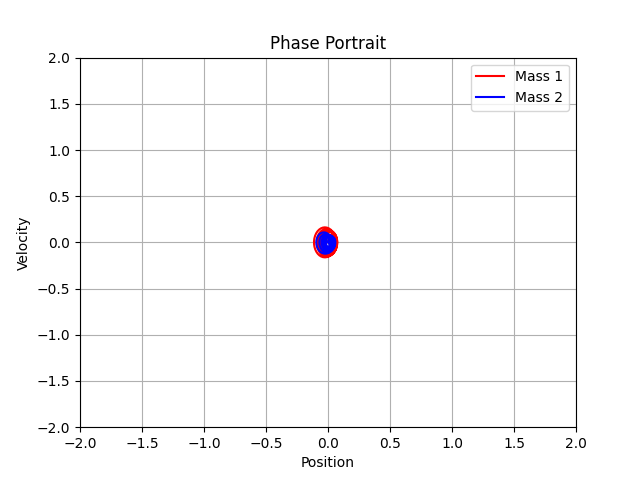

In [ ]:
phase_Portrait(0, 0, 0, 0)

### Initial Conditions

In [ ]:
x10 = 2
x10_Prime = 0
x20 = 0
x20_Prime = 0

y0 = np.array([x10, x10_Prime, x20, x20_Prime])

## Time Evolution Plot Code

In [ ]:
# Initial conditions
y0 = np.array([x10, x10_Prime, x20, x20_Prime])  # Initial conditions for y1 and y2 (x and x')

solution = odeint(coupled_oscillators, y0, t_List)
x1 = solution[:, 0]
x2 = solution[:, 2]
x1_prime = solution[:, 1]
x2_prime = solution[:, 3]

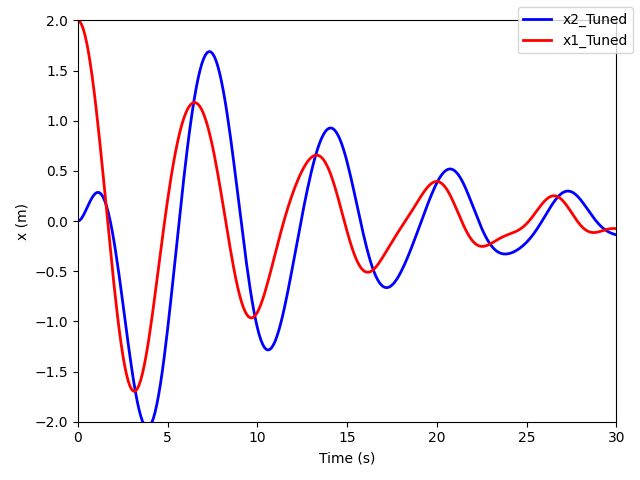

In [ ]:
fig, ax = plt.subplots()

# Set axis limits and labels
ax.set_xlim(0, tf)
ax.set_ylim(-2, 2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('x (m)')

# Plot Position
x2_Curve_Plot = ax.plot(t_List, x2, 'b', lw=2, label='x2_Tuned')
x1_Curve_Plot = ax.plot(t_List, x1, 'r', lw=2, label='x1_Tuned')

fig.set_tight_layout(True)

fig.legend()

## Solution Plot

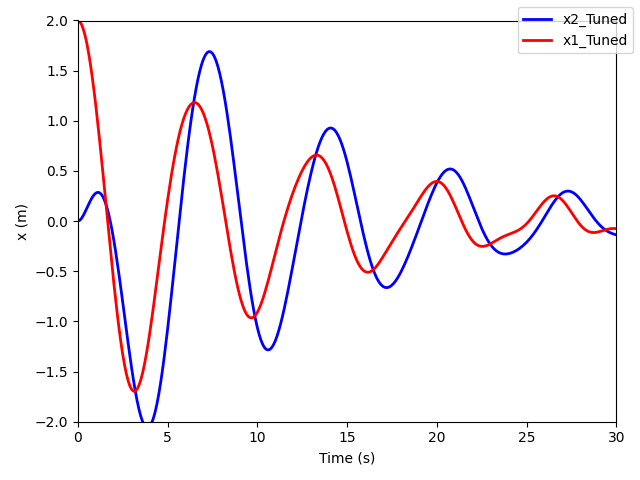

In [ ]:
fig.show()

### Animation Code

In [ ]:
def damped_Motion_Update(n):

  t = dt * n

  mass_1.set_xy((- 1/2 * mass_1_Size + mass_1_Equilibrium_Position + x1[n], y_Max/2 - mass_1_Size/2))
  spring_1.update_spring((0, spring_Heigth), (mass_1_Equilibrium_Position + x1[n] - mass_1_Size/2, spring_Heigth))
  damper_1.update_endpoints((0, damper_Heigth), (mass_1_Equilibrium_Position + x1[n] - mass_1_Size/2, damper_Heigth))

  mass_2.set_xy((- 1/2 * mass_2_Size + mass_2_Equilibrium_Position + x2[n], y_Max/2 - mass_2_Size/2))
  spring_2.update_spring((mass_1_Equilibrium_Position + x1[n] + mass_1_Size/2, spring_Heigth), (mass_2_Equilibrium_Position + x2[n] - mass_2_Size/2, spring_Heigth))
  damper_2.update_endpoints((mass_1_Equilibrium_Position + x1[n] + mass_1_Size/2, damper_Heigth), (mass_2_Equilibrium_Position + x2[n] - mass_2_Size/2, damper_Heigth))

  ax0_x1Scatter.set_data([x1[n]],[x1_prime[n]])
  ax0_x2Scatter.set_data([x2[n]],[x2_prime[n]])

  ax1_x1Scatter.set_data([t_List[n]],[x1[n]])
  ax1_x2Scatter.set_data([t_List[n]],[x2[n]])

  return()

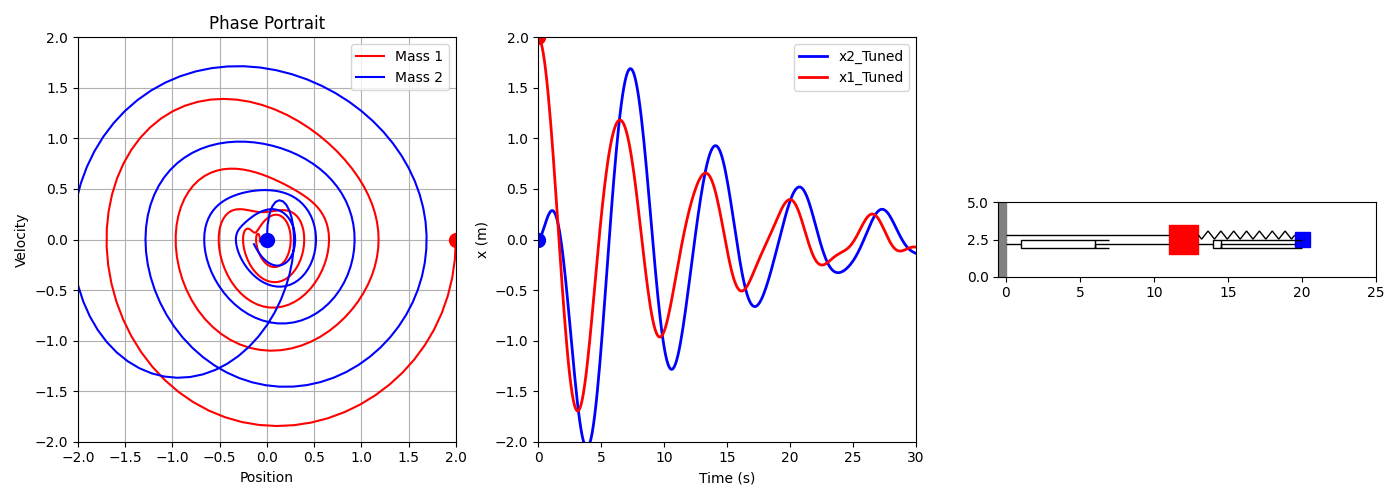

In [ ]:
# Creating subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

# Plotting phase portraits on the same plot

ax0.plot(x1, x1_prime, label='Mass 1', color='red')
ax0.plot(x2, x2_prime, label='Mass 2', color='blue')

ax0.set_xlim(-2, 2)
ax0.set_ylim(-2, 2)

ax0.set_xlabel('Position')
ax0.set_ylabel('Velocity')
ax0.set_title('Phase Portrait')
ax0.grid(True)
ax0.legend()

ax0_x1Scatter, = ax0.plot([x10], [x10_Prime], 'r.', ms=20)
ax0_x2Scatter, = ax0.plot([x20], [x20_Prime], 'b.', ms=20)




# Set axis limits and labels
ax1.set_xlim(0, tf)
ax1.set_ylim(-2, 2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('x (m)')

# Plot Position
x2_Curve_Plot = ax1.plot(t_List, x2, 'b', lw=2, label='x2_Tuned')
x1_Curve_Plot = ax1.plot(t_List, x1, 'r', lw=2, label='x1_Tuned')

fig.set_tight_layout(True)

ax1_x1Scatter, = ax1.plot([t_List[0]], [x10], 'r.', ms=20)
ax1_x2Scatter, = ax1.plot([t_List[0]], [x20], 'b.', ms=20)

ax1.legend()






# Set axis limits and labels

ax2.set_xlim(x_Min, x_Max)
ax2.set_ylim(y_Min, y_Max)

# Set aspect ratio to equal, i.e. circles are shown as circles

ax2.set_aspect('equal')

# Draw Wall

wall_Left = plt.Rectangle((-wall_Width, 0.), wall_Width, y_Max, color='grey')

ax2.add_patch(wall_Left)

# Draw Masses

mass_1 = plt.Rectangle((- 1/2 * mass_1_Size + mass_1_Equilibrium_Position + x1[0], y_Max/2 - mass_1_Size/2), mass_1_Size, mass_1_Size, color='red')
ax2.add_patch(mass_1)

mass_2 = plt.Rectangle((- 1/2 * mass_2_Size + mass_2_Equilibrium_Position + x2[0], y_Max/2 - mass_2_Size/2), mass_2_Size, mass_2_Size, color='blue')
ax2.add_patch(mass_2)

# Draw Springs

spring_1 = SpringPatch((0, spring_Heigth), (mass_1_Equilibrium_Position + x1[0] - mass_1_Size/2, spring_Heigth), spring_Nodes, spring_Width, edgecolor='black')
ax2.add_patch(spring_1)

spring_2 = SpringPatch((mass_1_Equilibrium_Position + x1[0] + mass_1_Size/2, spring_Heigth), (mass_2_Equilibrium_Position + x2[0] - mass_2_Size/2, spring_Heigth), spring_Nodes, spring_Width, edgecolor='black')
ax2.add_patch(spring_2)

# Draw Damping Element

damper_1 = DampingPatch((0, damper_Heigth), (mass_1_Equilibrium_Position + x1[0] - mass_1_Size/2, damper_Heigth), damper_lengthBase, damper_lengthTop, damper_lengthBox, damper_Width, edgecolor='black')
ax2.add_patch(damper_1)

damper_2 = DampingPatch((mass_1_Equilibrium_Position + x1[0] + mass_1_Size/2, damper_Heigth), (mass_2_Equilibrium_Position + x2[0] - mass_2_Size/2, damper_Heigth), damper_lengthBase, damper_lengthTop, damper_lengthBox, damper_Width, edgecolor='black')
ax2.add_patch(damper_2)

plt.show()


# # Animation

anim = animation.FuncAnimation(fig, damped_Motion_Update, frames = int(1 + tf * 1/dt ), interval=1000 * dt, blit=True, repeat = False)
rc('animation', html='html5')

### Animation

In [ ]:
anim